In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
# from fastai.fastai.text import *

In [4]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [5]:
!ls {PATH}

20_words.csv	 lines.tgz	    synth_words		   word_labels.csv
ascii		 models		    synth_words_50000.csv  words
chars.csv	 paragraphs	    synth_words.csv	   words_chars.csv
line_labels.csv  paragraphs.csv     tmp			   words.csv
lines		 paragraphs.tar.gz  word_char_ids.csv	   words.tgz


In [6]:
device = torch.device('cuda' if cuda.is_available else 'cpu')
device

device(type='cuda')

# Prelim

In [6]:
from PIL import Image

def open_image(fname):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(f'{PATH}/words/{f}')

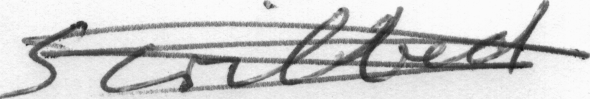

In [23]:
open_image('p06-047-08-00')

### Explore Data

In [27]:
# https://github.com/githubharald/SimpleHTR/blob/master/src/Model.py
    
# imgSize = (128, 32)
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])

In [28]:
data = np.stack(samples)
data.shape

(115320, 2)

In [61]:
data[:,1]

array(['A', 'MOVE', 'to', ..., 'the', 'garden', '?'],
      dtype='<U32')

In [29]:
len(chars)

78

### DataFrame (word images)

In [7]:
word_labels = pd.read_csv(f'{PATH}/ascii/words.txt', delim_whitespace=True, comment="#", header=None, usecols=range(0, 9))

In [8]:
word_labels.columns = ['filename','result','graylevel','x','y','w','h','tag','value']

In [9]:
word_labels.tail()

,filename,result,graylevel,x,y,w,h,tag,value
75597,r06-143-04-06,ok,186,1323,1428,64,77,PP3O,him
75598,r06-143-04-07,ok,186,1458,1469,36,52,IN,in
75599,r06-143-04-08,ok,186,1532,1445,73,72,ATI,the
75600,r06-143-04-09,ok,186,1654,1444,199,114,NN,garden
75601,r06-143-04-10,ok,186,1892,1453,36,66,?,?


In [ ]:
samp = word_labels.sample(8)
info = {f'{PATH}words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

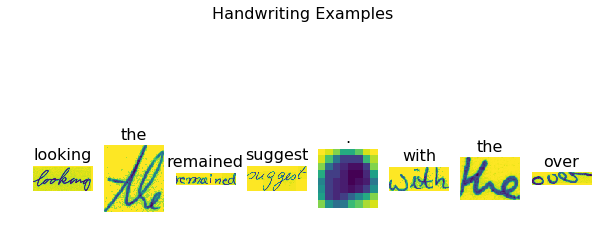

In [11]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

### check errors -> look OK

In [12]:
errors = word_labels[word_labels.result == 'err']

In [21]:
samp = errors.sample(8)
info = {f'{PATH}/words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

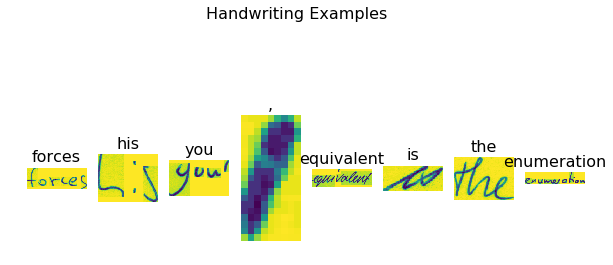

In [22]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

In [8]:
len(word_labels[word_labels.result == 'err']), len(word_labels)

(10847, 75604)

In [9]:
# remove all err results
# word_labels = word_labels[word_labels.result != 'err']
# len(word_labels)

64757

### Determine size of dataset (300,125)

In [51]:
# create a dictionary comprehension of image sizes in the dataset
size_d = {k: PIL.Image.open(PATH+k).size for k in data.val_ds.fnames}

In [52]:
row_sz,col_sz = list(zip(*size_d.values()))

In [53]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([ 2752.,  3277.,  2014.,  1023.,   406.,   168.,    49.,    18.,     4.,     3.]),
 array([   1. ,   85.1,  169.2,  253.3,  337.4,  421.5,  505.6,  589.7,  673.8,  757.9,  842. ]),
 <a list of 10 Patch objects>)

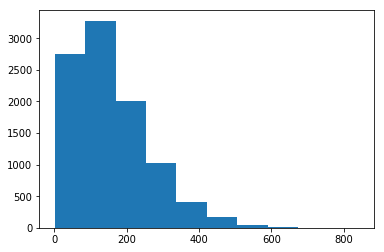

In [54]:
plt.hist(row_sz)

(array([  629.,  1338.,  2883.,  2678.,  1270.,   537.,   262.,    94.,    20.,     3.]),
 array([   1. ,   23.3,   45.6,   67.9,   90.2,  112.5,  134.8,  157.1,  179.4,  201.7,  224. ]),
 <a list of 10 Patch objects>)

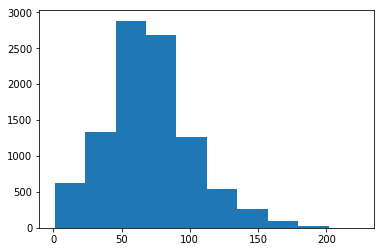

In [55]:
plt.hist(col_sz)

### Remove all rows where value count < 20 (word images)

In [10]:
# sort by label count
pivot = word_labels.pivot_table(index='value', aggfunc=len).sort_values('filename', ascending=False)
len(pivot)  # total num unique words

10867

In [11]:
# only keep values with counts > 20
pivot = pivot[pivot.filename > 5]
len(pivot)  # 344 unique words seen more than 20 times

1501

In [12]:
value_mask = np.array(pivot.index)
value_mask

array(['the', ',', '.', ..., 'opportunity', 'meetings', 'son'], dtype=object)

In [13]:
# apply value_mask to original csv
word_labels = word_labels[word_labels.value.isin(value_mask)]
len(word_labels)

60678

### Numericalize characters

In [21]:
itos = sorted(list(chars))
len(itos)

78

In [22]:
itos.insert(0, '_pad_')
itos.insert(1, '_unk_')

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in data[:,1]])

In [63]:
ids

array([array([28]), array([40, 42, 49, 32]), array([73, 68]), ..., array([73, 61, 58]),
       array([60, 54, 71, 57, 58, 67]), array([27])], dtype=object)

In [111]:
# convert to strings (as labels)
strs = np.array([' '.join(str(l) for l in w) for w in ids])

In [81]:
ids.shape, data.shape, strs.shape

((115320,), (115320, 2), (115320,))

In [112]:
# need to make strs a 2d array to allow for concatenation onto data
z = strs.reshape(-1,1)

In [113]:
data = np.concatenate((data, z), axis=1)
data[:10]

array([['a01-000u-00-00', 'A', '28'],
       ['a01-000u-00-01', 'MOVE', '40 42 49 32'],
       ['a01-000u-00-02', 'to', '73 68'],
       ['a01-000u-00-03', 'stop', '72 73 68 69'],
       ['a01-000u-00-04', 'Mr.', '40 71 13'],
       ['a01-000u-00-05', 'Gaitskell', '34 54 62 73 72 64 58 65 65'],
       ['a01-000u-00-06', 'from', '59 71 68 66'],
       ['a01-000u-01-00', 'nominating', '67 68 66 62 67 54 73 62 67 60'],
       ['a01-000u-01-01', 'any', '54 67 78'],
       ['a01-000u-01-02', 'more', '66 68 71 58']],
      dtype='<U95')

In [114]:
# convert numpy array to dataframe
df = pd.DataFrame(data, columns=['filename', 'label', 'values'])
df.head()

,filename,label,values
0,a01-000u-00-00,A,28
1,a01-000u-00-01,MOVE,40 42 49 32
2,a01-000u-00-02,to,73 68
3,a01-000u-00-03,stop,72 73 68 69
4,a01-000u-00-04,Mr.,40 71 13


In [23]:
np.save(TMP_PATH/'word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'word_itos.pkl', 'wb'))

### Save to CSV

In [79]:
ids = np.load(TMP_PATH/'word_ids.npy')
itos = pickle.load(open(TMP_PATH/'word_itos.pkl', 'rb'))

In [8]:
CSV = f'{PATH}/words.csv'

In [9]:
# csv.to_csv(CSV, columns=['filename', 'values'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,values
0,a01-000u-00-00,28
1,a01-000u-00-01,40 42 49 32
2,a01-000u-00-02,73 68
3,a01-000u-00-03,72 73 68 69
4,a01-000u-00-04,40 71 13


In [10]:
len(csv)

115318

### Words/Chars

In [7]:
WORDS = f'{PATH}/word_labels.csv'
CHARS = f'{PATH}/word_char_ids.csv'

In [9]:
# df.to_csv(CHARS, columns=['filename', 'values'], index=False)
chars = pd.read_csv(CHARS)
chars.head()

,filename,values
0,a01-000u-00-00,1 29
1,a01-000u-00-01,1 41 43 50 33
2,a01-000u-00-02,1 74 69
3,a01-000u-00-03,1 73 74 69 70
4,a01-000u-00-04,1 41 72 14


In [8]:
# df.to_csv(CHARS, columns=['filename', 'values'], index=False)
words = pd.read_csv(WORDS)
words.head()

,filename,label
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


### Get val_idxs

In [41]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

7426

### Preprocess (rotate, normalize)

In [10]:
f = resnet34
sz = 64
bs = 120

In [65]:
aug_tfms = [RandomRotate(5),  # transform type Classification
            RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs,
                                    tfms=tfms, suffix='.png', continuous=True)

In [66]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [42]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [18]:
x.shape

(50, 64, 64, 3)

In [19]:
y.shape

torch.Size([50, 11])

### View image transforms

In [46]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [47]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

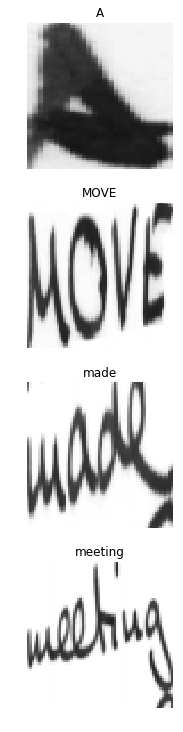

In [22]:
fig, axes = plt.subplots(4,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Simple Word CNN

In [7]:
CSV = f'{PATH}/20_words.csv'
# word_labels.to_csv(CSV, columns=['filename', 'value'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,value
0,a01-000u-00-00,A
1,a01-000u-00-02,to
2,a01-000u-00-04,Mr.
3,a01-000u-00-06,from
4,a01-000u-01-01,any


In [8]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

7425

In [9]:
f = resnet34
sz = 64
bs = 120

In [10]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png')

In [11]:
learn = ConvLearner.pretrained(f, data, ps=0.5, precompute=True)
learn.opt_fn = optim.Adam

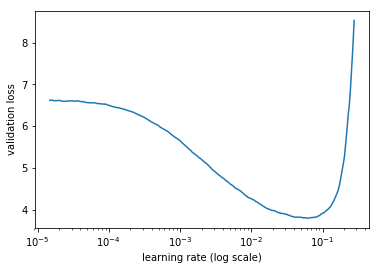

In [52]:
learn.lr_find()
learn.sched.plot()

In [53]:
lr = 1e-2

### Train

In [54]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.545029   2.128407   0.516294  
    1      2.253554   1.895877   0.562079                   


[1.8958774596380474, 0.5620791833419347]

In [55]:
learn.precompute=False

In [56]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      2.092959   1.763632   0.586588  
    1      1.970511   1.697019   0.598707                   
    2      1.925129   1.667942   0.602074                   


[1.6679421625399313, 0.602073795385127]

In [64]:
learn.save('words20-.60acc')

In [12]:
learn.unfreeze()

 74%|███████▎  | 258/351 [00:36<00:13,  6.98it/s, loss=7.42]

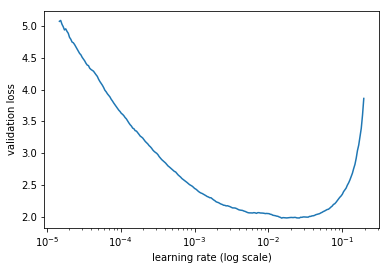

In [66]:
learn.lr_find()
learn.sched.plot()

In [67]:
lrs = np.array([lr/100, lr/30, lr/10])

In [68]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.263568   1.035006   0.741988  
    1      0.898641   0.72851    0.821034                    
    2      0.588655   0.605815   0.855642                    
    3      0.704174   0.635121   0.847428                    
    4      0.436175   0.512807   0.879208                    
    5      0.272617   0.468683   0.898196                    
    6      0.175207   0.455457   0.902774                    


[0.4554568621834879, 0.9027740378409359]

In [69]:
learn.save('words20-.90acc') # minimum frequency = 20
# learn.save('words-.49acc')   # minimum frequency = 5

### Predict

In [13]:
learn.load('words20-.90acc') # minimum frequency = 20

In [14]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs,y)

0.9676767676767677

In [19]:
preds = np.argmax(probs, axis=1)

### Results

In [15]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [16]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [35]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH/ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    labels = [data.classes[preds[x]] + ' - ' + data.classes[data.val_y[x]] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=labels, figsize=(16,8))

Correctly classified


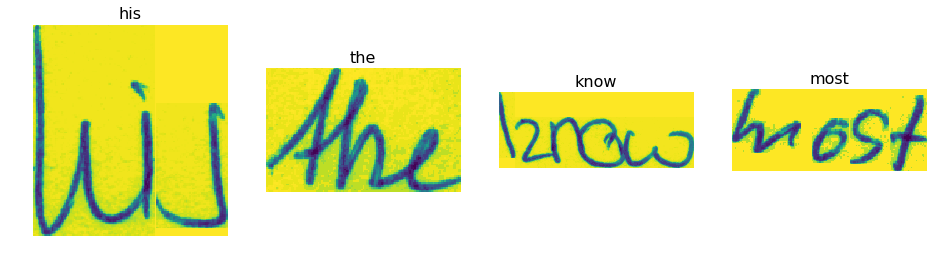

In [28]:
# correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


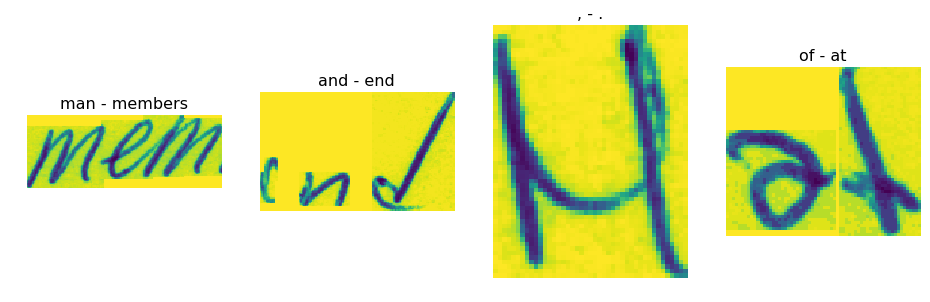

In [37]:
# incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

# Show, Attend, Tell Architecture (no attention)

In [67]:
vs = len(itos)
conv_model = nn.Sequential(*children(f(True))[:6]) #=> feature map of shape: (bs, 64, 25, 25)

In [68]:
em_sz,nh,sl = 256,512,20

In [69]:
# based on Show,Attend,Tell - https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py

class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=1):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 128, 20
        
        self.pool = nn.AdaptiveMaxPool2d(7)      #(bs,128,7,7)
        self.linear = nn.Linear(128*7*7, em_sz)  #(6272, 256)
        self.bn = nn.BatchNorm1d(em_sz, momentum=0.01)

        self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl) #, dropout=0.1)
        self.drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz, vs) #=> ([256, 80])
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)        #=> ([50, 128, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)       #=> ([50, 64, 7, 7])
        feats = feats.view(feats.size(0), -1)   #(bs,6272)
        feats = self.bn(self.linear(feats))     #(bs,256)
        bs,c = feats.size()   # need this because last batch isn't 50
        
        h = feats.unsqueeze(0)         #(1,bs,256)
    
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        dec_inp = V(torch.zeros(bs).long()) #=> ([bs])   # initialize first word and then replace 
        res = []

        for i in range(self.sl):            
            emb = self.emb(dec_inp).unsqueeze(0)         # embedding => ([1, bs, 256])
            outp, h = self.gru(emb, h)                   # rnn => ([1, bs, 256]),  ([1, bs, 256])
            outp = self.out(self.drop(outp[0]))          # dropout, linear layer => ([256, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])   #=> ([64])
#             if (dec_inp==1).all(): break       # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)                  # stack up list of results into single tensor and return it

In [70]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):    
    targ = target.transpose(0,1).contiguous()  # need to switch the axes to line up
    sl,bs = targ.size()   #=> ([13,50])
    sl_in,bs_in,nc = input.size()  #=> ([20, 50, 80])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:20,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

In [71]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

rnn = Seq2SeqCNN_RNN(to_gpu(conv_model), vs, em_sz, nh, 20)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

 61%|██████    | 598/981 [01:36<01:01,  6.22it/s, loss=2.96] 

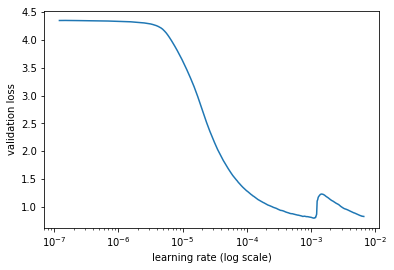

In [72]:
learn.lr_find(start_lr=1e-7)
learn.sched.plot()

In [73]:
lr = 2e-5

In [74]:
learn.fit(lr, 1, cycle_len=1)
#size:64,bs:100 -> .699
#size:128,bs:100 -> .718

epoch      trn_loss   val_loss                               
    0      0.774283   0.718428  


[0.7184280108854261]

In [75]:
learn.fit(lr, 1, cycle_len=1)
#size:64,bs:100 -> .648
#size:128,bs:100 -> .662

epoch      trn_loss   val_loss                               
    0      0.699162   0.66184   


[0.661839919972282]

### Test

In [54]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [55]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

In [56]:
def decode(probs):
    # probs.shape = ([20, 50, 80])
    probs = probs.permute(1, 0, 2).cpu().data.numpy()  #=> (50, 20, 80)
    return np.argmax(probs, 2)                        #=> (50, 20)

In [57]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

In [58]:
x.shape, y.shape

(torch.Size([100, 3, 64, 64]), torch.Size([100, 10]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


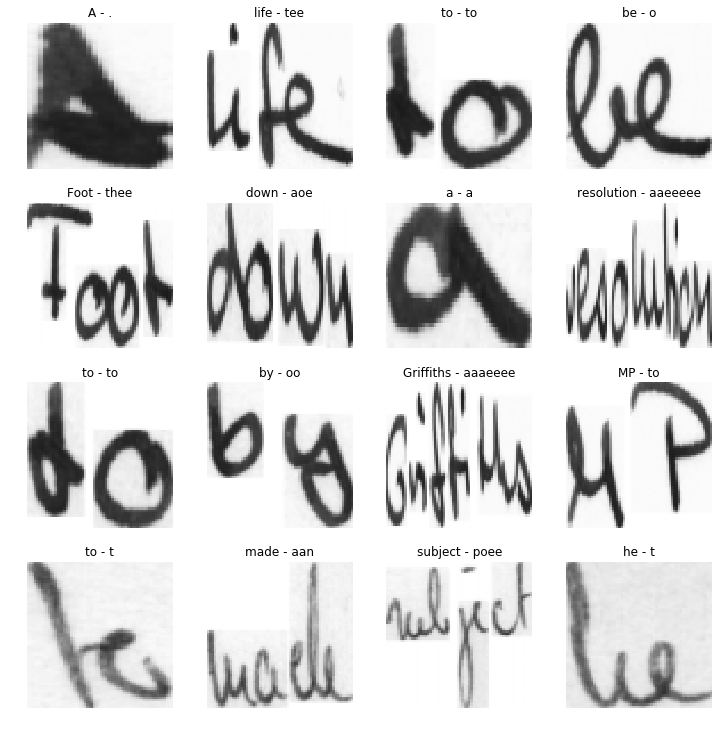

In [59]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Train

In [76]:
learn.fit(lr, 1, cycle_len=5, wds=1e-7, use_clr=(20,5))
# sz:64,bs:100
# epoch      trn_loss   val_loss                               
#     0      0.637314   0.618709  
#     1      0.596844   0.580925                               
#     2      0.582176   0.569669                               
#     3      0.566633   0.554469                               
#     4      0.55678    0.55116  

# sz:128,bs:100

epoch      trn_loss   val_loss                               
    0      0.658927   0.628848  
    1      0.618986   0.598999                               
    2      0.599512   0.581656                               
    3      0.583657   0.572389                               
    4      0.590647   0.568673                               


[0.5686734453102068]

In [77]:
learn.save('SAT-5-128')

In [62]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


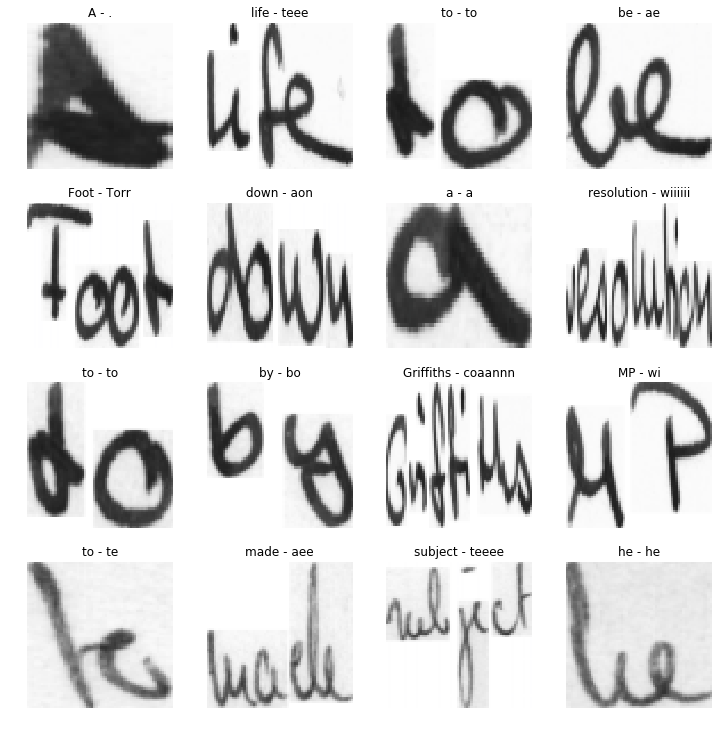

In [63]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Re-train

In [78]:
learn.fit(lr, 1, cycle_len=25, wds=1e-7, use_clr=(30,10))

epoch      trn_loss   val_loss                               
    0      0.581441   0.565209  
    1      0.568646   0.560204                               
    2      0.559949   0.543324                               
    3      0.543434   0.553036                               
    4      0.535154   0.523044                               
    5      0.529757   0.51615                                
    6      0.523101   0.51381                                
    7      0.515816   0.504342                               
    8      0.499973   0.500376                               
    9      0.49965    0.49102                                
    10     0.509083   0.488345                               
    11     0.496047   0.483304                               
    12     0.492401   0.480196                               
    13     0.485698   0.475823                               
    14     0.474124   0.47964                                
    15     0.485848   0.470555       

[0.45874813664166225]

In [79]:
learn.save('25-128v1')

In [80]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


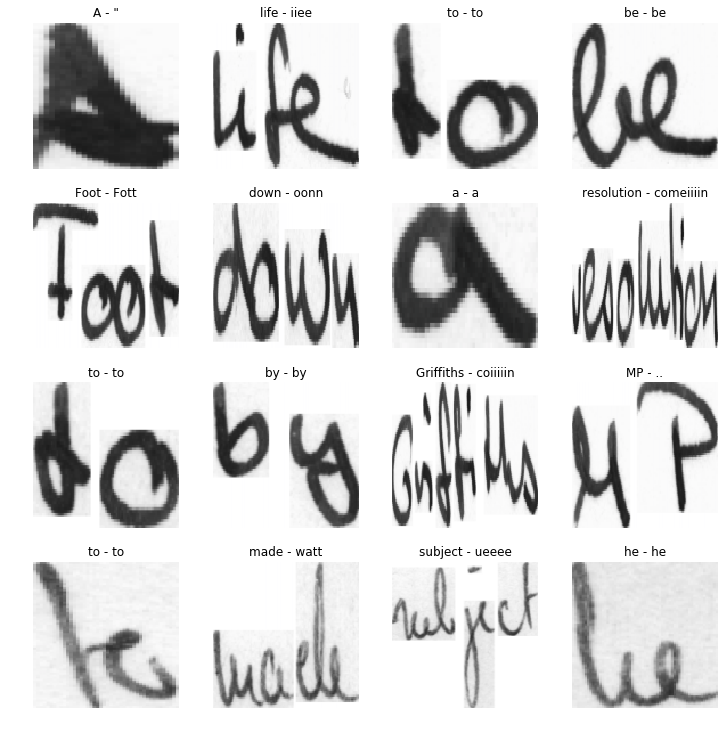

In [81]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# CRNN (no CTC loss)

**GRU**

Inputs: input, h_0
    - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
      of the input sequence. The input can also be a packed variable length
      sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
      for details.
    - **h_0** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the initial hidden state for each element in the batch.
      Defaults to zero if not provided.

Outputs: output, h_n
    - **output** of shape `(seq_len, batch, hidden_size * num_directions)`: tensor
      containing the output features h_t from the last layer of the GRU,
      for each t. If a :class:`torch.nn.utils.rnn.PackedSequence` has been
      given as the input, the output will also be a packed sequence.
    - **h_n** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the hidden state for `t = seq_len`

In [19]:
vs = len(itos)
conv_model = nn.Sequential(*children(f(True))[:5]) #=> feature map of shape: (bs, 64, 25, 25)

In [20]:
em_sz,nh,nl = 64,128,2

In [21]:
# based on CRNN - https://github.com/BelBES/crnn-pytorch/blob/master/models/crnn.py

class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 256, 20
        
        self.pool = nn.AdaptiveMaxPool2d((1,16)) # (h,w)
        self.reshape = nn.Conv2d(16,sl,1)

        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl, dropout=0.35)#, bidirectional=True)
        self.out = nn.Linear(em_sz, vs) #=> ([64, 80])
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)        #=> ([50, 64, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)       #=> ([50, 64, 1, 16])
        feats = feats.permute(0,3,2,1) #=> ([50, 16, 1, 64])
        feats = self.reshape(feats)    #=> ([50, 20, 1, 64])
        feats = feats.permute(1,0,2,3).squeeze(2)
        sl,bs,c = feats.size() #=> ([20, 50, 64])
        
        ### Decoder (RNN Layer) ###
        hidden = self.initHidden(bs)
        outp, hidden = self.gru(feats, hidden)    #=> ([20, 50, 64]),  ([2, 50, 64])            
        return self.out(outp)                     #=> ([20, 50, 80])   
   
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, em_sz))

In [22]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):
    targ = target.transpose(0,1).contiguous()  # need to switch the axes to line up
    sl,bs = targ.size()   #=> ([13,50])
    sl_in,bs_in,nc = input.size()  #=> ([20, 50, 80])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:20,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

In [23]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [24]:
rnn = Seq2SeqCNN_RNN(to_gpu(conv_model), vs, em_sz, nh, 20)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

 73%|███████▎  | 1428/1961 [07:25<02:46,  3.21it/s, loss=3.21]

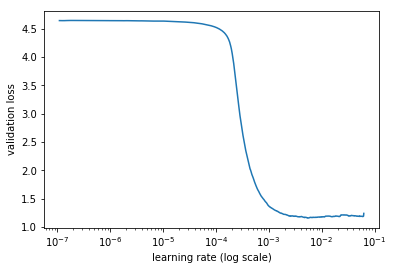

In [23]:
learn.lr_find(start_lr=1e-7)
learn.sched.plot()

Plateau -> Bad initialization??

In [25]:
lr = 2e-4

In [24]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.725681   0.71784   



[0.7178396868567936]

In [25]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.668954   0.672449  



[0.6724488909189412]

### Test

In [38]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [39]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

In [26]:
def decode(probs):
    # probs.shape = ([20, 50, 80])
    probs = probs.permute(1, 0, 2).cpu().data.numpy()  #=> (50, 20, 80)
    return np.argmax(probs, 2)                        #=> (50, 20)

In [43]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

In [42]:
x.shape, y.shape

(torch.Size([50, 3, 64, 64]), torch.Size([50, 9]))

In [45]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Re-train

In [55]:
learn.fit(lr, 1, cycle_len=5, wds=1e-7, use_clr=(20,5))

epoch      trn_loss   val_loss                                 
    0      0.659955   0.658877  
    1      0.655576   0.643377                                 
    2      0.645276   0.642052                                 
    3      0.640512   0.631085                                 
    4      0.639652   0.630313                                 



[0.6303129358098686]

In [60]:
learn.save('0.630')

In [58]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


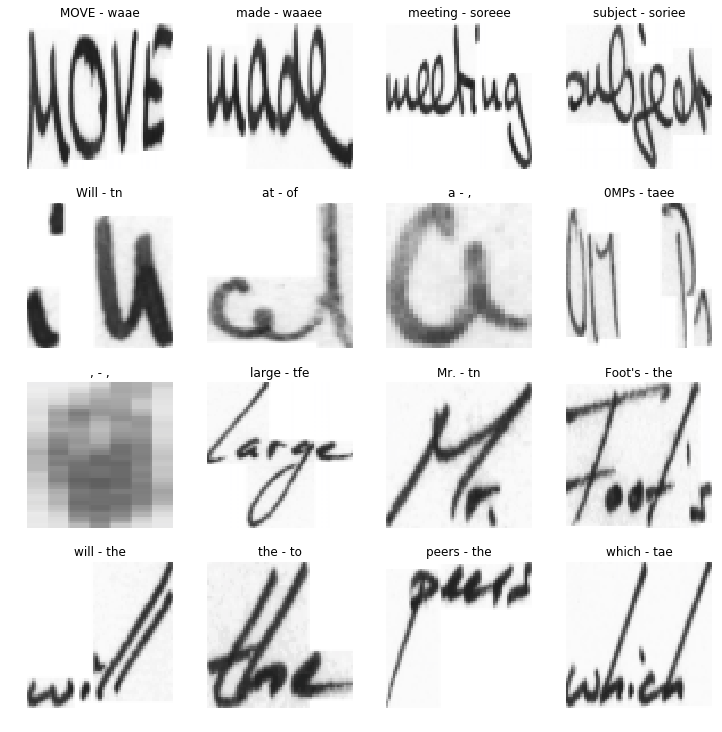

In [59]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Re-train

In [ ]:
learn.fit(lr, 1, cycle_len=25, wds=1e-7, use_clr=(30,10))

In [62]:
learn.save('25v1')

In [63]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


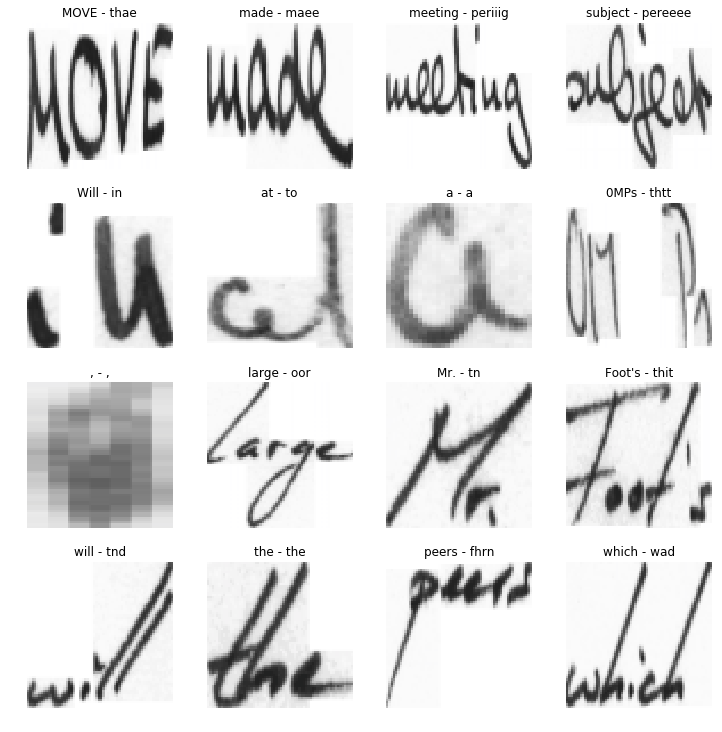

In [64]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Re-train

In [43]:
learn.load('25v1')

In [44]:
learn.fit(lr, 1, cycle_len=25, wds=1e-7, use_clr=(30,10))

epoch      trn_loss   val_loss                                 
    0      0.569287   0.560624  
    1      0.571092   0.560462                                 
    2      0.568191   0.557557                                 
    3      0.563074   0.555592                                 
    4      0.579691   0.548323                                 
    5      0.570379   0.546512                                 
    6      0.552641   0.553476                                 
    7      0.568227   0.541602                                 
    8      0.565848   0.539576                                 
    9      0.54571    0.538416                                 
    10     0.564224   0.538626                                 
    11     0.565668   0.534471                                 
    12     0.549617   0.534053                                 
    13     0.566993   0.534001                                 
    14     0.544475   0.530867                                 
    15 

[0.5255540623141162]

In [45]:
learn.save('25v2')

In [46]:
x,y = next(iter(learn.data.val_dl))
probs = learn.model(V(x))                          
preds = decode(probs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


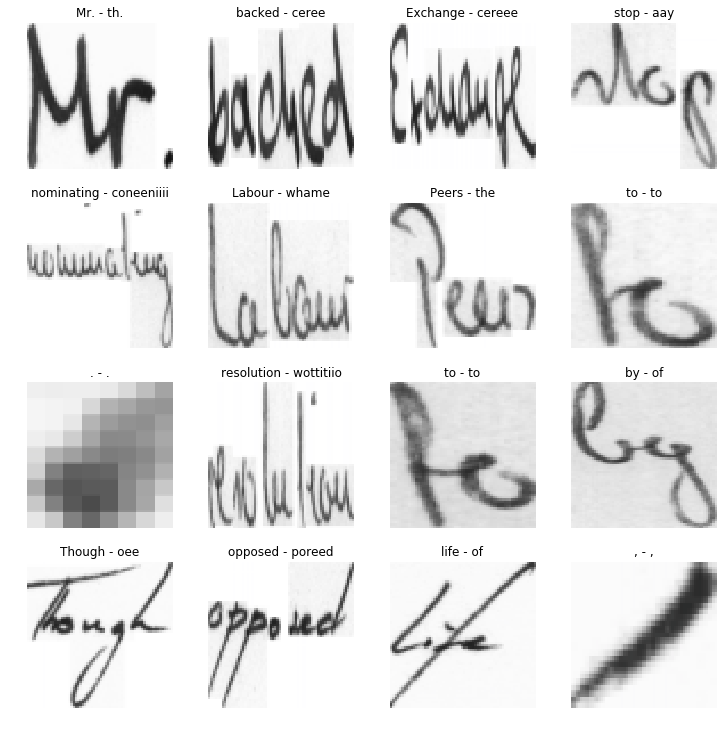

In [47]:
imgs = denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i]) + ' - ' + label_text(preds[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)